In [1]:
import pickle
from typing import Iterable, Optional, Literal

import cheetah
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.utils import shuffle
from torch import nn
from tqdm import trange

In [2]:
def batched(iterable: Iterable, size: int = 1) -> Iterable:
    length = len(iterable)
    for ndx in range(0, length, size):
        yield iterable[ndx : min(ndx + size, length)]

In [3]:
# Load data from two different runs

with open("rl_firstsub_real_32.pkl", "rb") as f:
    rl_data = pickle.load(f)

with open("bo_firstsub_real_32.pkl", "rb") as f:
    bo_data = pickle.load(f)

with open("rl_sim_33.pkl", "rb") as f:
    rl_data_sim = pickle.load(f)

In [4]:
real_combined = {"observations": rl_data["observations"] + bo_data["observations"]}

In [5]:
# Load ARES lattice and wrap it in normalisation nn.Module


class NormalizedARESEAMisalignments(nn.Module):
    """
    Wrapper around the ARES experimental area lattice that normalises the
    quadrupole misalignments.
    """

    MAX_MISALIGNMENT = 0.5e-3  # 0.5 mm

    def __init__(
        self, incoming: Literal["rl_sim_data", "centered_astra"] = "centered_astra"
    ):
        super().__init__()

        self.ares_ea = cheetah.Segment.from_lattice_json(
            "ARESlatticeStage3v1_9.json"
        ).subcell("AREASOLA1", "AREABSCR1")

        # Load a beam that's close to a design beam and move it to zero mu. Zero mu is
        # assumed because we need to define origin somehow and at ARES ballistic
        # trajectory is preferred.
        if incoming == "rl_sim_data":
            incoming_parameters = rl_data_sim["observations"][0]["incoming"]
            self.incoming_beam = cheetah.ParameterBeam.from_parameters(
                energy=torch.tensor(incoming_parameters[0], dtype=torch.float32),
                mu_x=torch.tensor(incoming_parameters[1], dtype=torch.float32),
                mu_xp=torch.tensor(incoming_parameters[2], dtype=torch.float32),
                mu_y=torch.tensor(incoming_parameters[3], dtype=torch.float32),
                mu_yp=torch.tensor(incoming_parameters[4], dtype=torch.float32),
                sigma_x=torch.tensor(incoming_parameters[5], dtype=torch.float32),
                sigma_xp=torch.tensor(incoming_parameters[6], dtype=torch.float32),
                sigma_y=torch.tensor(incoming_parameters[7], dtype=torch.float32),
                sigma_yp=torch.tensor(incoming_parameters[8], dtype=torch.float32),
                sigma_s=torch.tensor(incoming_parameters[9], dtype=torch.float32),
                sigma_p=torch.tensor(incoming_parameters[10], dtype=torch.float32),
            )
        elif incoming == "centered_rl_sim_data":
            incoming_parameters = rl_data_sim["observations"][0]["incoming"]
            self.incoming_beam = cheetah.ParameterBeam.from_parameters(
                energy=torch.tensor(incoming_parameters[0], dtype=torch.float32),
                mu_x=torch.tensor(0.0),
                mu_xp=torch.tensor(0.0),
                mu_y=torch.tensor(0.0),
                mu_yp=torch.tensor(0.0),
                sigma_x=torch.tensor(incoming_parameters[5], dtype=torch.float32),
                sigma_xp=torch.tensor(incoming_parameters[6], dtype=torch.float32),
                sigma_y=torch.tensor(incoming_parameters[7], dtype=torch.float32),
                sigma_yp=torch.tensor(incoming_parameters[8], dtype=torch.float32),
                sigma_s=torch.tensor(incoming_parameters[9], dtype=torch.float32),
                sigma_p=torch.tensor(incoming_parameters[10], dtype=torch.float32),
            )
        elif incoming == "centered_astra":
            self.incoming_beam = cheetah.ParameterBeam.from_astra(
                "ACHIP_EA1_2021.1351.001"
            ).transformed_to(
                mu_x=torch.tensor(0.0),
                mu_y=torch.tensor(0.0),
                mu_xp=torch.tensor(0.0),
                mu_yp=torch.tensor(0.0),
            )
        else:
            raise ValueError(f"Unknown incoming beam {incoming}")

        self.normalized_misalignments_q1 = nn.Parameter(torch.randn(2) * 2 - 1)
        self.normalized_misalignments_q2 = nn.Parameter(torch.randn(2) * 2 - 1)
        self.normalized_misalignments_q3 = nn.Parameter(torch.randn(2) * 2 - 1)

    def forward(self, magnet_settings):
        # Set the magnet settings as they were in the ground truth sample
        self.ares_ea.AREAMQZM1.k1 = magnet_settings[0]
        self.ares_ea.AREAMQZM2.k1 = magnet_settings[1]
        self.ares_ea.AREAMCVM1.angle = magnet_settings[2]
        self.ares_ea.AREAMQZM3.k1 = magnet_settings[3]
        self.ares_ea.AREAMCHM1.angle = magnet_settings[4]

        # Set the misalignments based on the normalised misalignments
        self.ares_ea.AREAMQZM1.misalignment = (
            self.normalized_misalignments_q1 * self.MAX_MISALIGNMENT
        )
        self.ares_ea.AREAMQZM2.misalignment = (
            self.normalized_misalignments_q2 * self.MAX_MISALIGNMENT
        )
        self.ares_ea.AREAMQZM3.misalignment = (
            self.normalized_misalignments_q3 * self.MAX_MISALIGNMENT
        )

        return self.ares_ea.track(self.incoming_beam)

In [6]:
def train_normalized(model: nn.Module, num_epochs: int, data: dict) -> dict:
    misalignment_q1_history = []
    misalignment_q2_history = []
    misalignment_q3_history = []
    beam_parameter_history = []
    loss_history = []

    magnet_settings = torch.tensor([obs["magnets"] for obs in data["observations"]])
    measured_beams = torch.tensor([obs["beam"] for obs in data["observations"]])

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    for _ in trange(num_epochs):
        epoch_misalignment_q1_history = []
        epoch_misalignment_q2_history = []
        epoch_misalignment_q3_history = []
        epoch_beam_parameter_history = []
        epoch_loss_history = []

        magnet_settings, measured_beams = shuffle(magnet_settings, measured_beams)
        magnet_settings_2, measured_beams_2 = shuffle(magnet_settings, measured_beams)

        optimizer.zero_grad()

        for (
            magnet_setting_batch,
            measured_beam_batch,
            magnet_setting_2_batch,
            measured_beam_2_batch,
        ) in zip(
            batched(magnet_settings, 10),
            batched(measured_beams, 10),
            batched(magnet_settings_2, 10),
            batched(measured_beams_2, 10),
        ):
            batch_loss_history = []

            for magnet_setting, measured_beam, magnet_setting_2, measured_beam_2 in zip(
                magnet_setting_batch,
                measured_beam_batch,
                magnet_setting_2_batch,
                measured_beam_2_batch,
            ):
                outgoing_beam = model(magnet_setting)
                simulated_beam = torch.stack([outgoing_beam.mu_x, outgoing_beam.mu_y])
                outgoing_beam_2 = model(magnet_setting_2)
                simulated_beam_2 = torch.stack(
                    [outgoing_beam_2.mu_x, outgoing_beam_2.mu_y]
                )
                measured_beam_change = (measured_beam_2 - measured_beam)[[0, 2]]
                simulated_beam_change = simulated_beam_2 - simulated_beam
                sample_loss = F.mse_loss(
                    simulated_beam_change / 2e-3, measured_beam_change / 2e-3
                )

                batch_loss_history.append(sample_loss)

                epoch_loss_history.append(sample_loss.detach().numpy())
                epoch_beam_parameter_history.append(simulated_beam.detach().numpy())
                epoch_misalignment_q1_history.append(
                    model.ares_ea.AREAMQZM1.misalignment.detach().numpy()
                )
                epoch_misalignment_q2_history.append(
                    model.ares_ea.AREAMQZM2.misalignment.detach().numpy()
                )
                epoch_misalignment_q3_history.append(
                    model.ares_ea.AREAMQZM3.misalignment.detach().numpy()
                )

            loss = torch.stack(batch_loss_history).mean()
            loss.backward()

            optimizer.step()

        # Log epoch history
        loss_history.append(np.mean(epoch_loss_history))
        beam_parameter_history.append(np.mean(epoch_beam_parameter_history, axis=0))
        misalignment_q1_history.append(np.mean(epoch_misalignment_q1_history, axis=0))
        misalignment_q2_history.append(np.mean(epoch_misalignment_q2_history, axis=0))
        misalignment_q3_history.append(np.mean(epoch_misalignment_q3_history, axis=0))

    history = {
        "loss": loss_history,
        "beam_parameters": beam_parameter_history,
        "misalignment_q1": misalignment_q1_history,
        "misalignment_q2": misalignment_q2_history,
        "misalignment_q3": misalignment_q3_history,
    }
    return history

In [7]:
def plot_training(history: dict, ground_truth: Optional[np.ndarray] = None) -> None:
    plt.figure(figsize=(16, 3))

    plt.subplot(1, 3, 1)
    plt.plot(history["loss"])
    # plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")

    plt.subplot(1, 3, 2)
    plt.plot([record[0] for record in history["misalignment_q1"]], label="AREAMQZM1")
    plt.plot([record[0] for record in history["misalignment_q2"]], label="AREAMQZM2")
    plt.plot([record[0] for record in history["misalignment_q3"]], label="AREAMQZM3")
    if ground_truth is not None:
        plt.axhline(ground_truth[0], color="tab:blue", linestyle="--")
        plt.axhline(ground_truth[2], color="tab:orange", linestyle="--")
        plt.axhline(ground_truth[4], color="tab:green", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Quadrupole misalignment in x (m)")
    plt.title("x misalignments")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot([record[1] for record in history["misalignment_q1"]], label="AREAMQZM1")
    plt.plot([record[1] for record in history["misalignment_q2"]], label="AREAMQZM2")
    plt.plot([record[1] for record in history["misalignment_q3"]], label="AREAMQZM3")
    if ground_truth is not None:
        plt.axhline(ground_truth[1], color="tab:blue", linestyle="--")
        plt.axhline(ground_truth[3], color="tab:orange", linestyle="--")
        plt.axhline(ground_truth[5], color="tab:green", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Quadrupole misalignment in y (m)")
    plt.title("y misalignments")
    plt.legend()

    plt.tight_layout()
    plt.show()

/var/folders/z8/vzg_1dr50gg1zchydp1styc00000gn/T/ipykernel_52941/3868145760.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  magnet_settings = torch.tensor([obs["magnets"] for obs in data["observations"]])
100%|██████████| 1500/1500 [02:42<00:00,  9.26it/s]


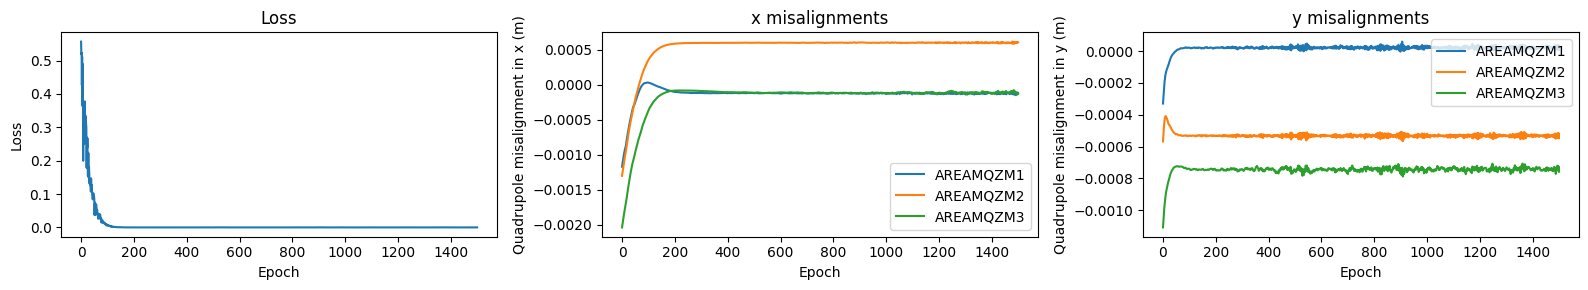

In [8]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_astra")
history = train_normalized(model=normalized_ares_ea, num_epochs=1_500, data=rl_data)
plot_training(history)

100%|██████████| 1500/1500 [02:42<00:00,  9.24it/s]


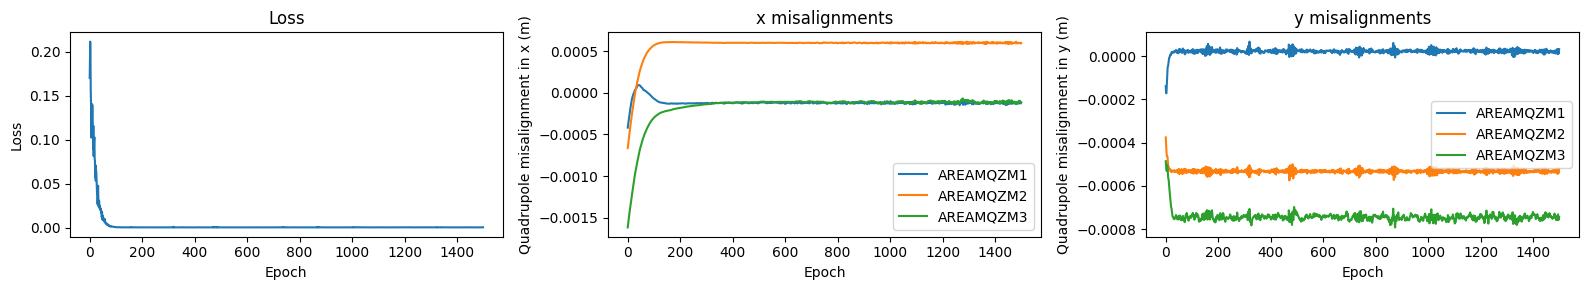

In [9]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_astra")
history = train_normalized(model=normalized_ares_ea, num_epochs=1_500, data=rl_data)
plot_training(history)

100%|██████████| 1500/1500 [02:37<00:00,  9.53it/s]


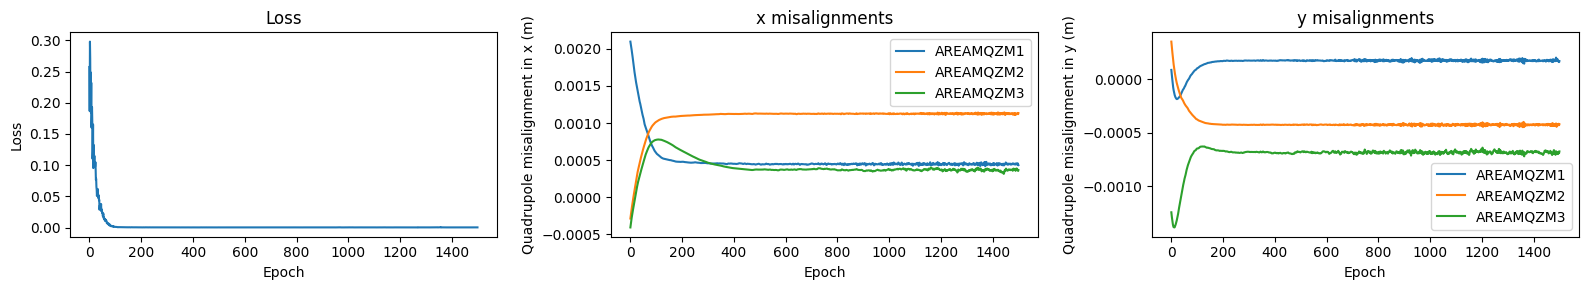

In [10]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="rl_sim_data")
history = train_normalized(model=normalized_ares_ea, num_epochs=1_500, data=rl_data)
plot_training(history)

100%|██████████| 1500/1500 [02:39<00:00,  9.42it/s]


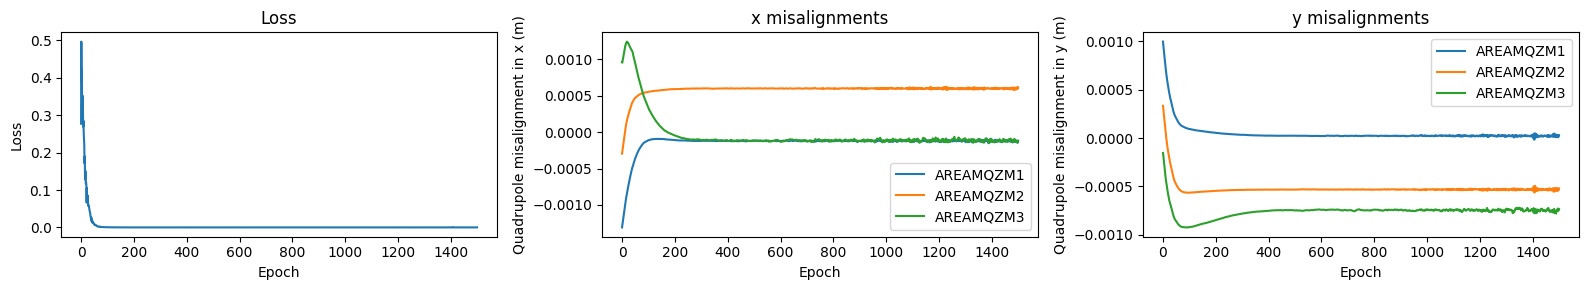

In [11]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_rl_sim_data")
history = train_normalized(model=normalized_ares_ea, num_epochs=1_500, data=rl_data)
plot_training(history)

100%|██████████| 1000/1000 [02:48<00:00,  5.93it/s]


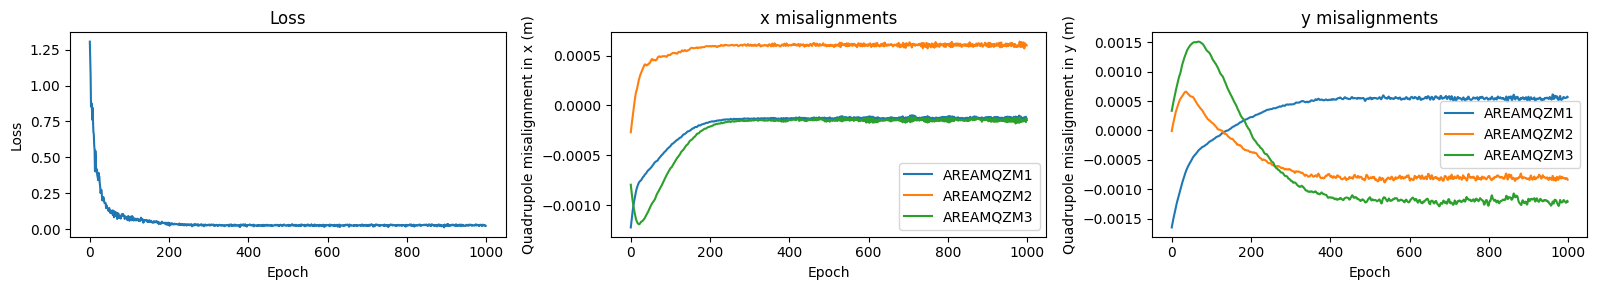

In [12]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_astra")
history = train_normalized(model=normalized_ares_ea, num_epochs=1_000, data=bo_data)
plot_training(history)

100%|██████████| 600/600 [02:48<00:00,  3.55it/s]


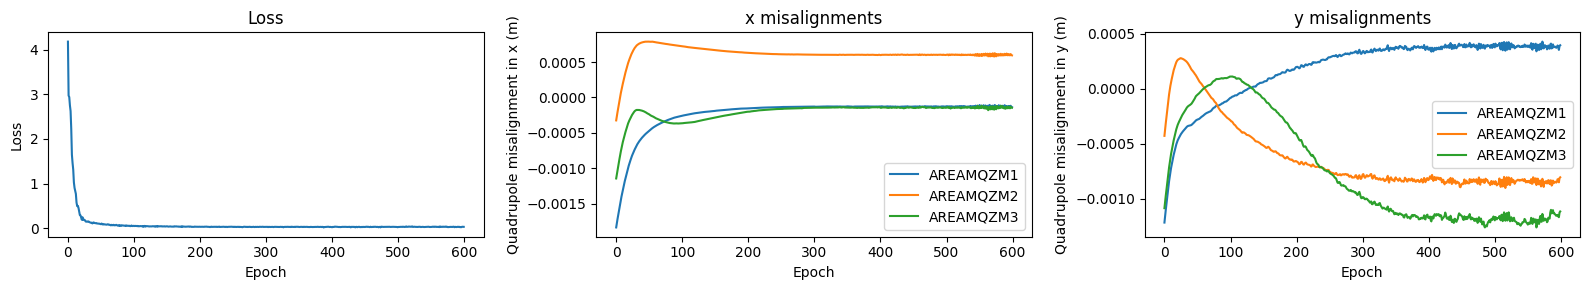

In [13]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_astra")
history = train_normalized(model=normalized_ares_ea, num_epochs=600, data=real_combined)
plot_training(history)

100%|██████████| 500/500 [02:40<00:00,  3.12it/s]


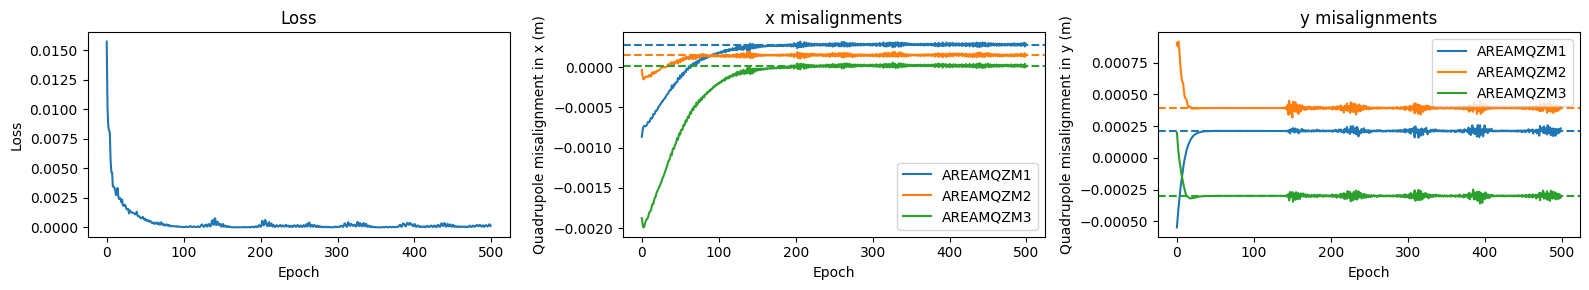

In [14]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="rl_sim_data")
history = train_normalized(model=normalized_ares_ea, num_epochs=500, data=rl_data_sim)
plot_training(history, ground_truth=rl_data_sim["observations"][0]["misalignments"])

100%|██████████| 500/500 [02:45<00:00,  3.03it/s]


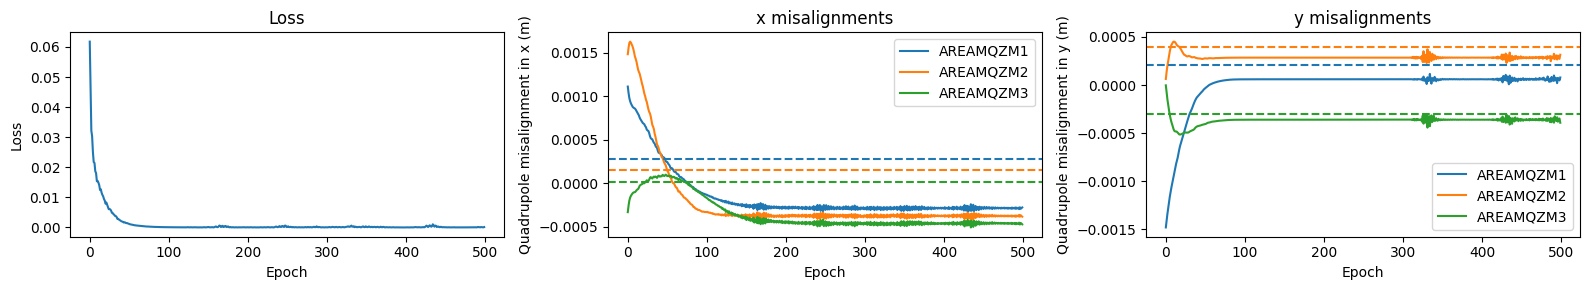

In [15]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_astra")
history = train_normalized(model=normalized_ares_ea, num_epochs=500, data=rl_data_sim)
plot_training(history, ground_truth=rl_data_sim["observations"][0]["misalignments"])

100%|██████████| 500/500 [02:35<00:00,  3.22it/s]


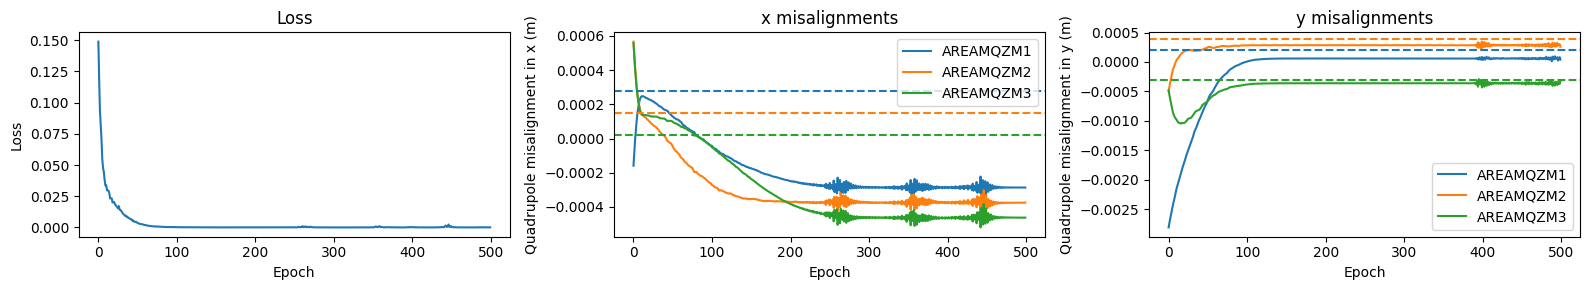

In [16]:
normalized_ares_ea = NormalizedARESEAMisalignments(incoming="centered_rl_sim_data")
history = train_normalized(model=normalized_ares_ea, num_epochs=500, data=rl_data_sim)
plot_training(history, ground_truth=rl_data_sim["observations"][0]["misalignments"])